## Model

In [43]:
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import keras
from keras import layers, ops
import matplotlib.pyplot as plt
keras.utils.set_random_seed(42)
tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True) 

# os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

In [2]:
# retrieve all video name

frames_path = 'data/frames/'
frames_path_normal = 'data/frames/Normal/'
frames_path_crash = 'data/frames/Crash/'

frames_name_normal = sorted([f for f in os.listdir(frames_path_normal)])
frames_name_crash = sorted([f for f in os.listdir(frames_path_crash)])

# 111

In [3]:
# I haven't implement any random retrieval yet
# so, 50 videos in total, 25 normla vid, 25 crash vid
# and 5 normal vid and 5 crash vid for validation

frames_name_normal_valid = frames_name_normal[26:28]
frames_name_crash_valid = frames_name_normal[26:28]

frames_name_normal = frames_name_normal[1:26]
frames_name_crash = frames_name_crash[1:26]

In [4]:
# 3-7 train test split

train_normal, test_normal = train_test_split(frames_name_normal,test_size=0.3, random_state=42)
train_crash, test_crash = train_test_split(frames_name_crash, test_size=0.3, random_state=42)

# 111

In [5]:
# `##` --> Adjustable

# DATA
IMG_SIZE = 128  ## Image size (128, 128) in this case
CHAN_SIZE = 1   # 1-GrayScale; 3-RGB
BATCH_SIZE = 8  ## 16, 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (50, IMG_SIZE, IMG_SIZE, CHAN_SIZE)
NUM_CLASSES = 2  # 1-Crash; 0-Normal

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
# EPOCHS = 10

# TUBELET EMBEDDING
PATCH_SIZE = (8,8,8) ##
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
EMBED_DIM = 64   ## Size of the feature vectors transformed from the input
NUM_HEADS =  6   ##
NUM_LAYERS = 6   ##

In [6]:
# Load data

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=CHAN_SIZE)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0 # Normalization
    return image

train_videos = []
test_videos = []
train_labels = []
test_labels = []

for t in train_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(0)
    
for t in test_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(0)

for t in train_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(1)
    
for t in test_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(1)

    
valid_videos = []
valid_labels = []
    
for t in frames_name_crash_valid:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(1)

for t in frames_name_normal_valid:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(0)

    
train_videos = np.asarray(train_videos)
test_videos = np.asarray(test_videos)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
valid_videos = np.asarray(valid_videos)
valid_labels = np.asarray(valid_labels)

# print(len(train_videos), len(train_labels)) # 34, 34
# print(len(test_videos), len(test_labels)) # 16, 16

In [9]:
# Create Dataloader

def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader


trainloader = prepare_dataloader(train_videos, train_labels, "train")
testloader = prepare_dataloader(test_videos, test_labels, "test")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")

# Create Embedding Mechanism

class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        
        # `projected_patches`
        # dividing the input into patches (determined by kernel_size and strides) 
        # and transforming each patch into an 64-dimensional embedding.
        
        projected_patches = self.projection(videos) 
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

# Create Positional Mechanism

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = ops.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

# The CustomMultiHeadAttention for outputting attention output and attention scores

# class CustomMultiHeadAttention(layers.Layer):
#     def __init__(self, num_heads, key_dim, dropout=0, **kwargs):
#         super().__init__(**kwargs)
#         self.attention = layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=key_dim, dropout=dropout
#         )
#     def call(self, query, value):
#         attention_output, attention_scores = self.attention(query, value, value)
#         return attention_output, attention_scores

In [20]:
""" REFERENCE

IMG_SIZE = 128
CHAN_SIZE = 1
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (50, IMG_SIZE, IMG_SIZE, CHAN_SIZE)
NUM_CLASSES = 2

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

PATCH_SIZE = (8,8,8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

LAYER_NORM_EPS = 1e-6
EMBED_DIM = 64
NUM_HEADS =  6
NUM_LAYERS = 6

"""

def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=EMBED_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape) # shape=(50,128,128,1)
    # Create patches
    patches = tubelet_embedder(inputs)
    # Encode patches
    encoded_patches = positional_encoder(patches)


    for _ in range(transformer_layers):
        
        # 1. Layer normalization and MultiHeadAttention
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # 2. The MultiHeadAttention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)
        
        # 3. Skip connection - Mitigate Vanishing Gradient Problem
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # 4. Layer Normalization and MultiLayerPerception
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        ## 111
        # 5. The two fully-connected layers with GELU activation functions
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim, activation=ops.gelu), 
                layers.Dense(units=embed_dim, activation=ops.gelu),
            ]
        )(x3)
        
#       # 5. Try expanding 64 dimension embedding to 256 for capturing data complexity
#         x3 = keras.Sequential(
#             [
#                 layers.Dense(units=embed_dim*4, activation=ops.gelu), 
#                 layers.Dense(units=embed_dim, activation=ops.gelu),
#             ]
#         )(x3)
        
        # 6. Skip connection - - Mitigate Vanishing Gradient Problem
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [21]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=EMBED_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=EMBED_DIM)
    )

    # Compile the model with the optimizer, loss function and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model
    # You may definn the epochs here
    # 111
    history = model.fit(trainloader, epochs=5, validation_data=validloader)

    return model, history

model, history = run_experiment()

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 49s 9s/step - accuracy: 0.7029 - loss: 0.9078 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.7868 - val_top-5-accuracy: 1.0000
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.4352 - loss: 1.2066 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.0655 - val_top-5-accuracy: 1.0000
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.7312 - loss: 0.6328 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7543 - val_top-5-accuracy: 1.0000
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - accuracy: 0.8555 - loss: 0.4252 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.9056 - val_top-5-accuracy: 1.0000
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 9s/step - accuracy: 0.8138 - loss: 0.3776 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.1552 - val_top-5-accuracy: 1.0000


## Visualization

## 1. Weight Distribution and Bias Distribution

In [62]:
# A more comprehensive view of what model had been trying to do

model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 50, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tubelet_embedding_… │ (None, 1536, 64)  │     32,832 │ input_layer_28[0… │
│ (TubeletEmbedding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoder… │ (None, 1536, 64)  │     98,304 │ tubelet_embeddin… │
│ (PositionalEncoder) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1536, 64)  │     99,520 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 230,784 (901.50 KB)

 Trainable params: 230,784 (901.50 KB)

 Non-trainable params: 0 (0.00 B)

# 11

In [63]:
for layer in model.layers:
    print(layer.__class__.__name__)

InputLayer
TubeletEmbedding
PositionalEncoder
LayerNormalization
MultiHeadAttention


In [14]:
# Extract Weights and Biases from the Two Dense Layers

"""
x3 = keras.Sequential(
    [
        layers.Dense(units=embed_dim, activation=ops.gelu), # Dense Layer 1
        layers.Dense(units=embed_dim, activation=ops.gelu), # Dense Layer 2
    ]
)(x3)
"""

weights = []

for layer in model.layers:
    if (layer.__class__.__name__ == "Sequential"):
        weights.append(layer.get_weights())

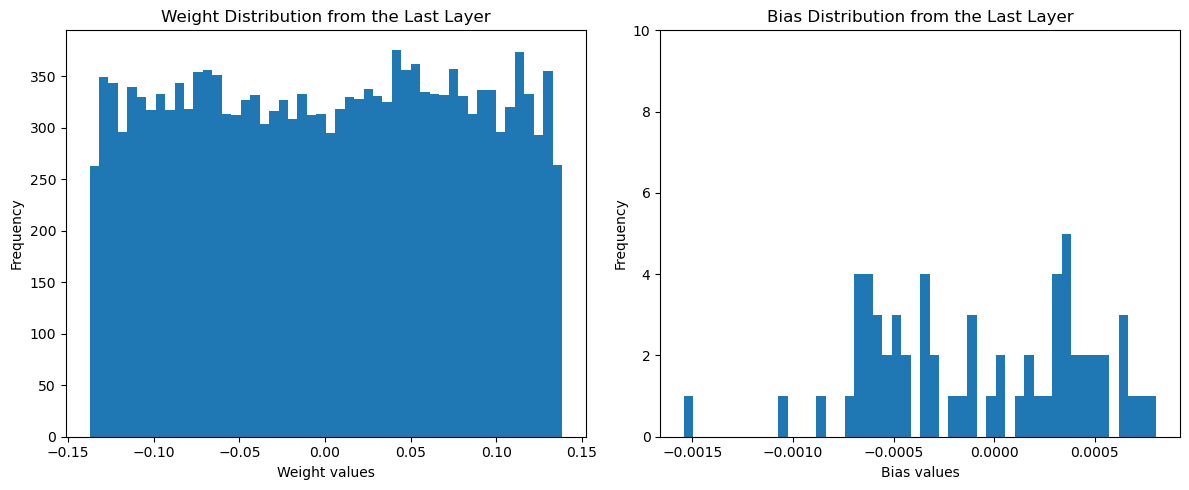

In [37]:
# Get the Weights and Biases form the LAST Dense Layer

w = weights[-1] # Last dense layer
# index 0 - 第一个Dense Layer的Weights
# index 1 - 第一个Dense Layer的Bias
weight_matrix_last = w[2] # 第二个Dense Layer的Weights
bias_matrix_last = w[3] # 第二个Dense Layer的Bias

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Weight Distribution from the Last Layer")
plt.hist(weight_matrix_last.flatten(), bins=50)
plt.xlabel("Weight values")
plt.ylabel("Frequency")
# plt.ylim(0, 120)
plt.subplot(1, 2, 2)
plt.title("Bias Distribution from the Last Layer")
plt.hist(bias_matrix_last.flatten(), bins=50)
plt.xlabel("Bias values")
plt.ylabel("Frequency")
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

### Observation

* Weight Distribution - Uniform?
* Bias Distribution - Is it close to Gaussian, if not, maybe a problem?

## 2. Model Evaluation

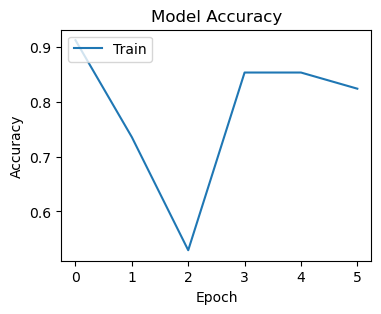

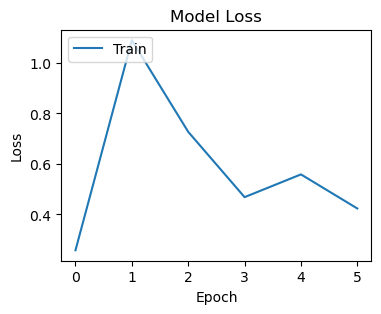

In [16]:
# Accuracy and Loss
plt.figure(figsize=(4, 3))
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.figure(figsize=(4, 3))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model Evaluation using Testloader

In [23]:
# Evaluate 16 testing videos

model_predict_test = model.predict(testloader)

In [30]:
# Inspect Test Results

pred = []
normal_count = 0
misclassified_indicies = []

for i in range(16):
    
    crash_conf = model_predict_test[i][0]
    normal_conf = model_predict_test[i][1]
    
    if (crash_conf > normal_conf):
        print("Prediction: Crash", crash_conf)
        pred.append(1)
    else:
        print("Prediction: Normal", normal_conf)
        pred.append(0)
        normal_count += 1
        
    if (i < 8):
        print("Actual:     Crash", test_normal[i]+".mp4")
    else:
        print("Actual:     Normal", test_crash[abs(i-8)]+".mp4")
    print()

print(str(abs(len(test_labels)-normal_count)) + " videos out of 16 videos are classified as Crash")
print(str(normal_count) + " videos out of 16 videos are classified as Normal")

Prediction: Crash 0.7548805
Actual:     Crash 000009.mp4

Prediction: Crash 0.75127983
Actual:     Crash 000017.mp4

Prediction: Normal 0.7676368
Actual:     Crash 000001.mp4

Prediction: Crash 0.9392463
Actual:     Crash 000024.mp4

Prediction: Normal 0.7431279
Actual:     Crash 000012.mp4

Prediction: Normal 0.74492264
Actual:     Crash 000010.mp4

Prediction: Crash 0.77647525
Actual:     Crash 000014.mp4

Prediction: Normal 0.8125053
Actual:     Crash 000002.mp4

Prediction: Normal 0.87398434
Actual:     Normal 000009.mp4

Prediction: Normal 0.9165446
Actual:     Normal 000017.mp4

Prediction: Normal 0.7816835
Actual:     Normal 000001.mp4

Prediction: Normal 0.86163145
Actual:     Normal 000024.mp4

Prediction: Normal 0.7778499
Actual:     Normal 000012.mp4

Prediction: Normal 0.6390752
Actual:     Normal 000010.mp4

Prediction: Normal 0.8812375
Actual:     Normal 000014.mp4

Prediction: Normal 0.7696762
Actual:     Normal 000002.mp4

4 videos out of 16 videos are classified as Cra

**Bias towards Classifying Videos to Normal Class?**

## Confusion Matrix (TF vs. TN vs. FP vs. FN)

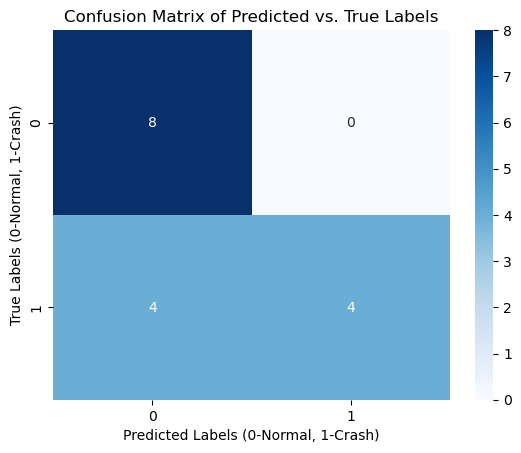

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true = [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0]

cm = confusion_matrix(true, pred)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels (0-Normal, 1-Crash)')
plt.ylabel('True Labels (0-Normal, 1-Crash)')
plt.title('Confusion Matrix of Predicted vs. True Labels')
plt.show()

## Feature Bias

In [64]:
import pandas as pd
weight_matrix_last_df = pd.DataFrame(weight_matrix_last)
weight_matrix_last_df

# The full row of the weight matrix is the weights of all features to one outcomes
# The full column of the weight matrix is the weights of one feature to all outcomes

# Note: Outcome number = EMBED_DIM

0         1         2         3         4         5         6   \
0   -0.104577  0.014368  0.013328  0.133212 -0.006134  0.107151  0.100355   
1    0.085201 -0.118042  0.052575  0.022760 -0.127746 -0.125616  0.101763   
2    0.002819 -0.070938  0.067052 -0.064623 -0.011774 -0.059971  0.024683   
3   -0.009797  0.049058  0.011291  0.030123 -0.114776 -0.063547  0.127802   
4   -0.123632  0.019021  0.120768  0.074413  0.115182 -0.026606 -0.029856   
..        ...       ...       ...       ...       ...       ...       ...   
251 -0.043194 -0.026734  0.048473 -0.105104  0.018676 -0.082139  0.065292   
252  0.035735 -0.012116  0.135370  0.133295 -0.053540  0.125734 -0.113690   
253 -0.104348  0.098027 -0.123420  0.028347  0.109435  0.086262  0.057398   
254  0.058038  0.066195 -0.059085  0.095270 -0.034523 -0.107542 -0.009767   
255 -0.045145 -0.044358  0.008226 -0.020026 -0.032662  0.115195 -0.003366   

           7         8         9   ...        54        55        56  \
0    0.024930  0.034020 -0.053422  ... -0.082670  0.050374 -0.096828   
1   -0.020066 -0.124522 -0.090447  ... -0.049814 -0.124668  0.088955   
2    0.062161  0.049980  0.097150  ...  0.048909 -0.048750  0.052300   
3    0.113974 -0.098578 -0.090022  ... -0.044739  0.089495  0.129562   
4   -0.117669 -0.095554 -0.056843  ... -0.103341 -0.105653  0.128387   
..        ...       ...       ...  ...       ...       ...       ...   
251 -0.084818  0.070619 -0.130058  ...  0.130383 -0.034679 -0.053925   
252 -0.052581 -0.105367 -0.009516  ...  0.105349 -0.061258  0.077093   
253 -0.120031 -0.001291 -0.009465  ...  0.067014 -0.094626  0.021581   
254 -0.103401  0.014956  0.018355  ... -0.099031  0.065339  0.022178   
255  0.082497  0.046303 -0.000707  ...  0.069552  0.052883 -0.058512   

           57        58        59        60        61        62        63  
0    0.111045 -0.106820  0.044024  0.124832 -0.136028  0.125374 -0.046873  
1   -0.006550  0.015961 -0.008243  0.068712  0.084265  0.070253 -0.083731  
2   -0.059238 -0.082832 -0.032563 -0.071246  0.054680  0.062271 -0.134573  
3   -0.050115  0.134374  0.078329  0.030075 -0.058512  0.074034 -0.070656  
4    0.119916  0.098842 -0.125268 -0.084712  0.033341  0.125489 -0.068687  
..        ...       ...       ...       ...       ...       ...       ...  
251 -0.100878 -0.097009  0.028730 -0.000794 -0.115178 -0.060578  0.036171  
252 -0.083843 -0.031749  0.029648 -0.119647  0.013547 -0.054813  0.003046  
253  0.071551  0.113850 -0.091739  0.092486  0.132264 -0.016350 -0.131825  
254  0.133518  0.002266 -0.107993  0.002581 -0.065271 -0.079504 -0.105400  
255 -0.068079 -0.045759  0.064019 -0.052524 -0.110971  0.026077 -0.067403  

[256 rows x 64 columns]

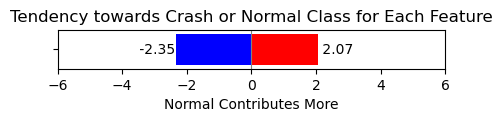

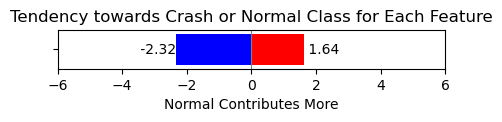

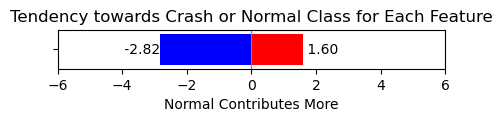

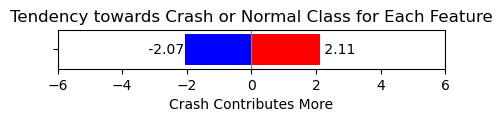

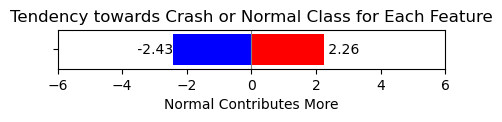

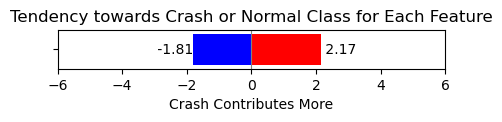

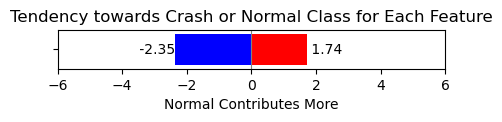

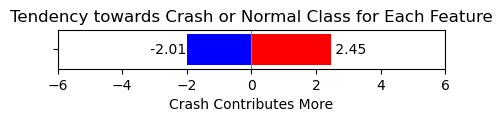

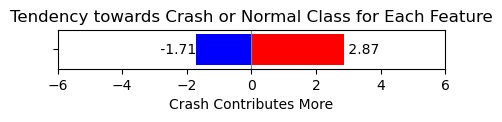

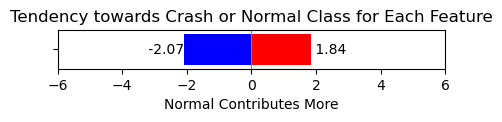

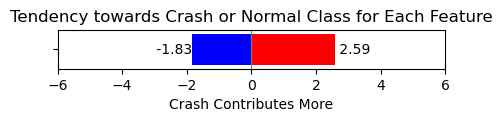

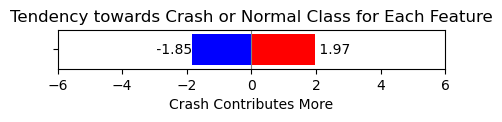

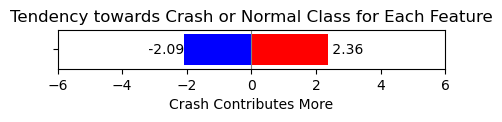

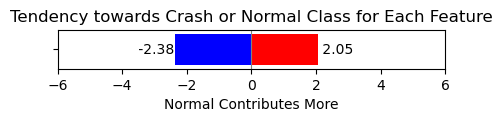

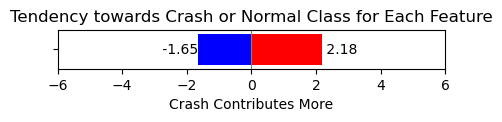

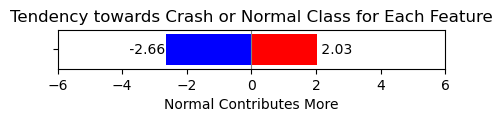

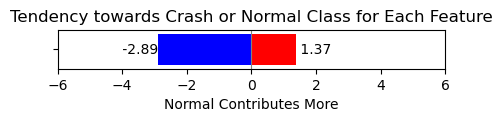

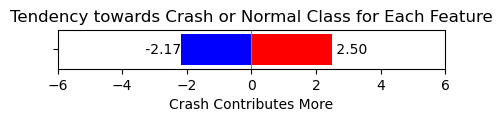

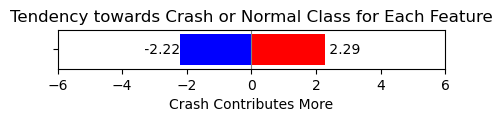

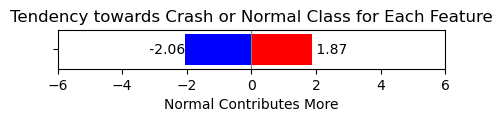

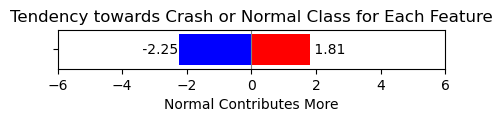

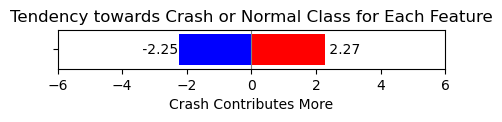

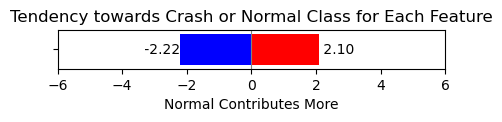

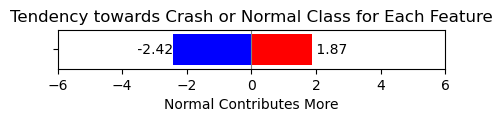

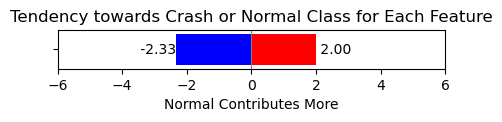

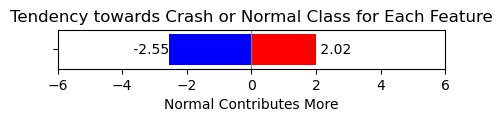

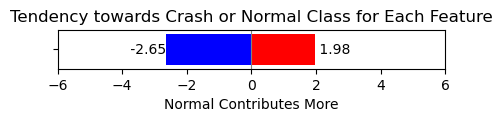

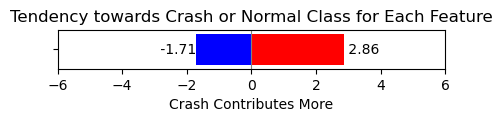

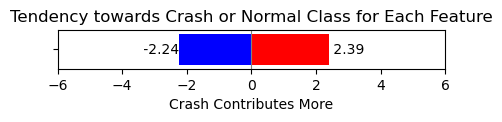

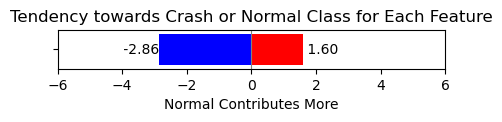

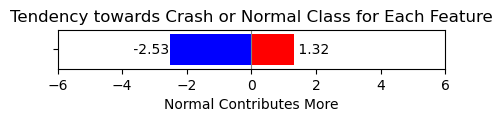

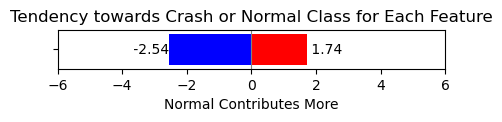

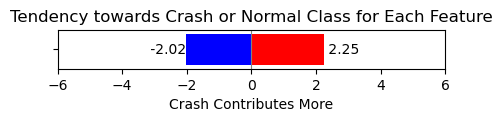

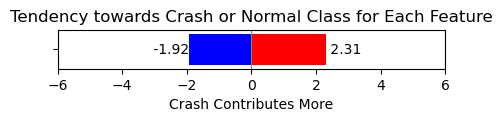

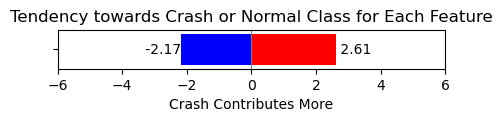

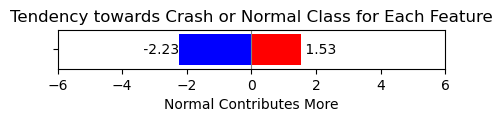

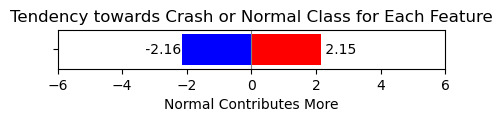

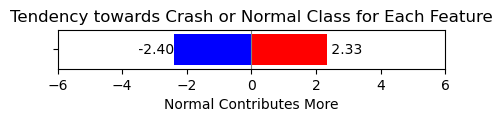

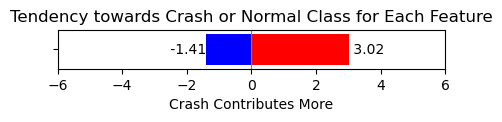

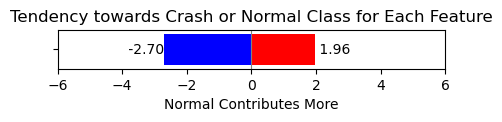

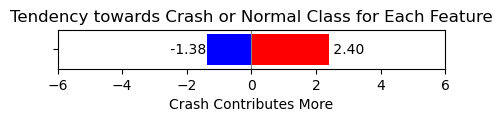

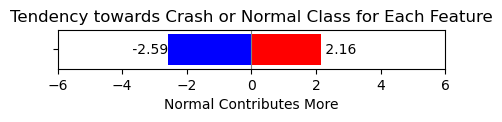

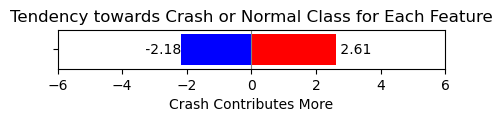

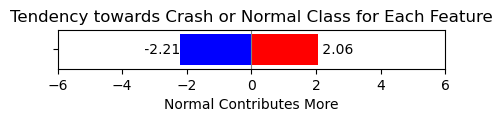

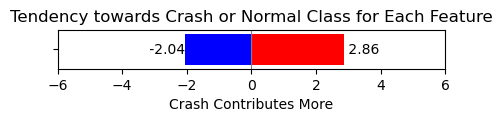

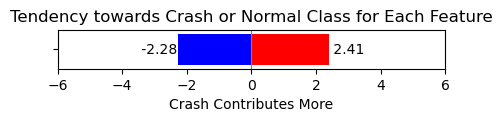

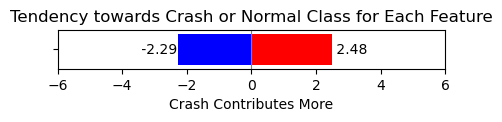

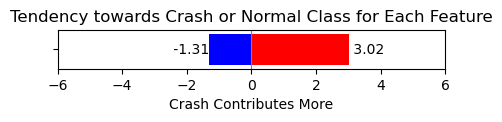

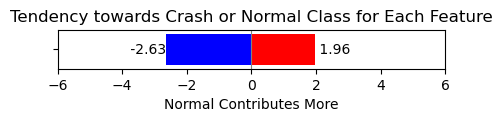

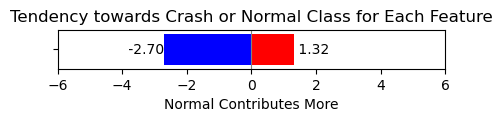

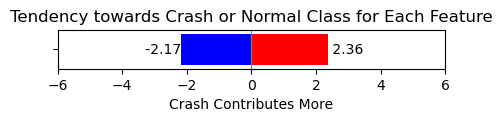

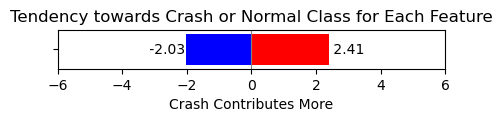

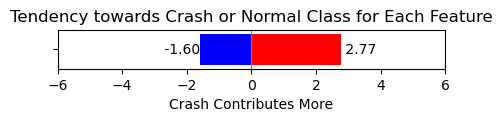

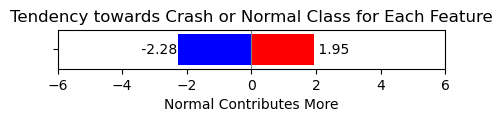

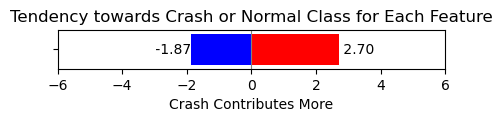

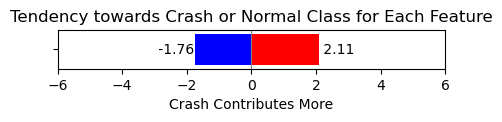

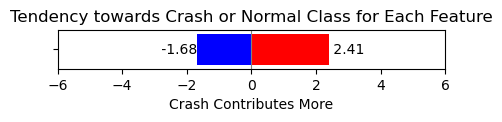

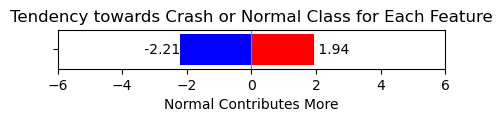

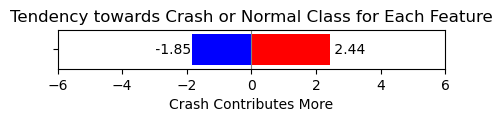

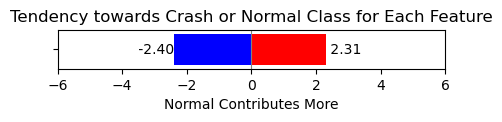

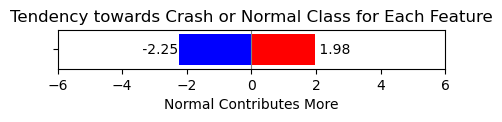

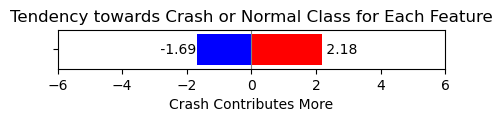

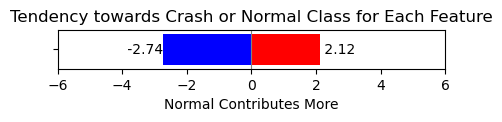

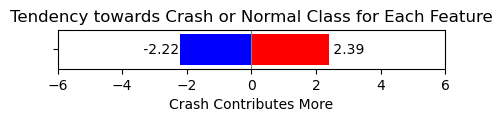

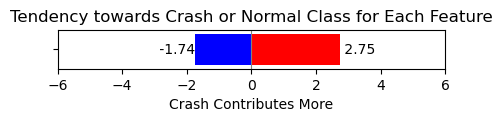

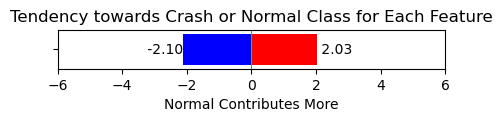

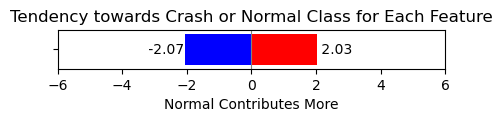

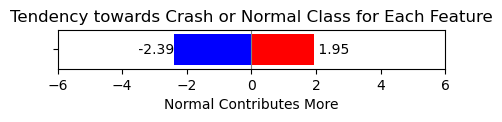

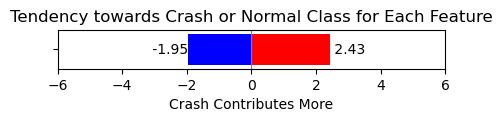

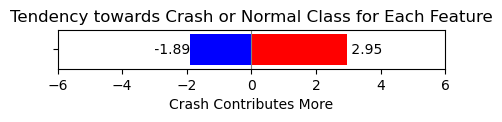

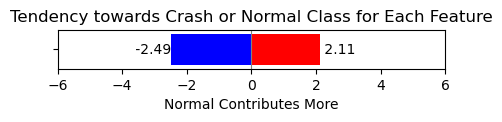

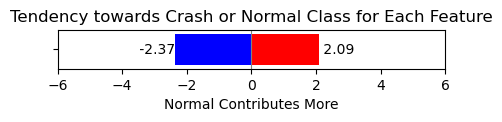

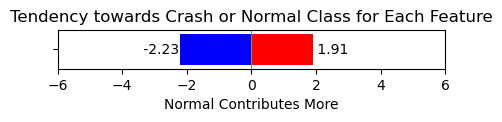

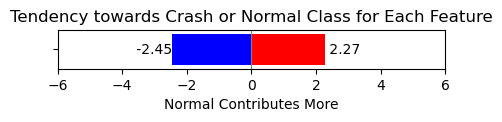

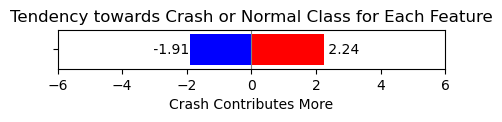

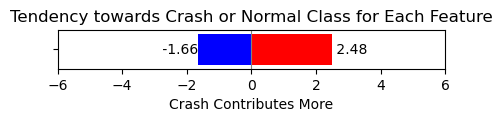

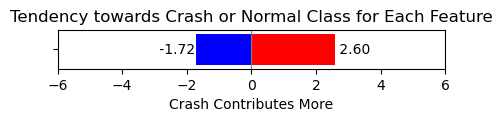

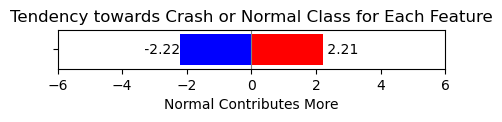

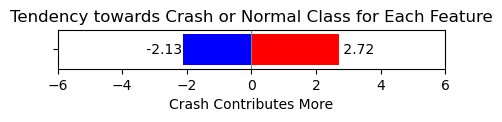

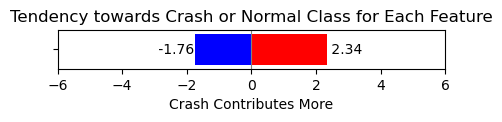

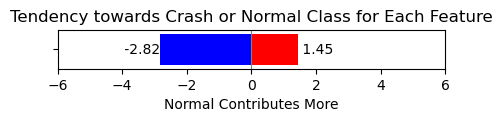

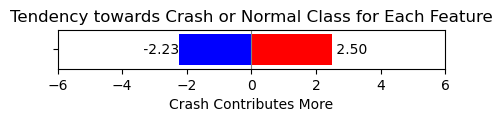

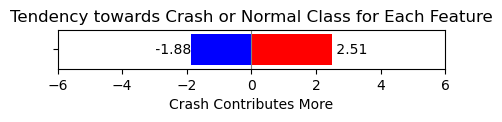

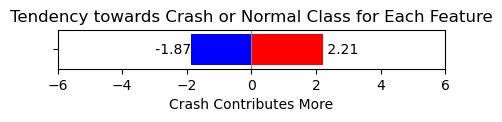

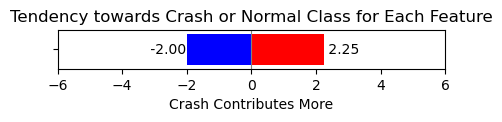

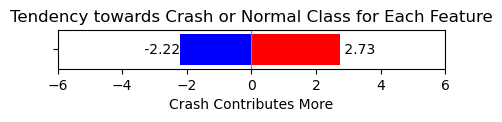

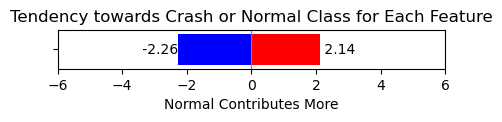

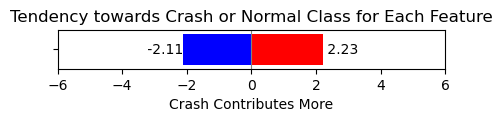

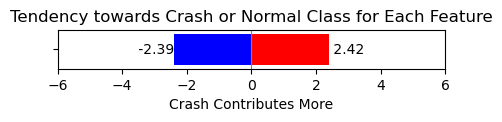

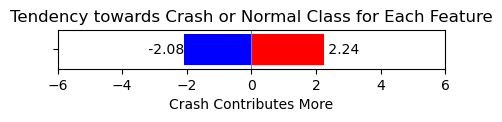

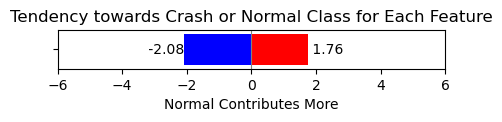

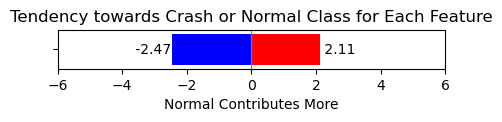

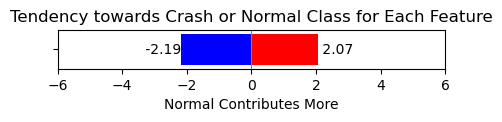

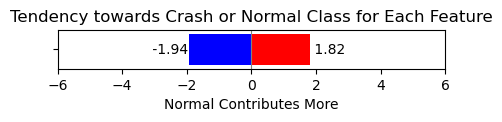

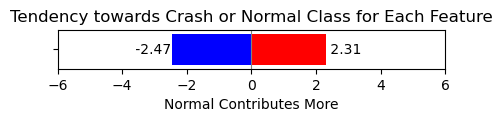

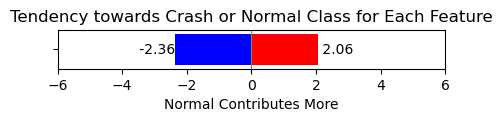

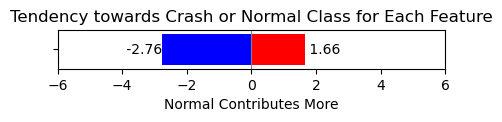

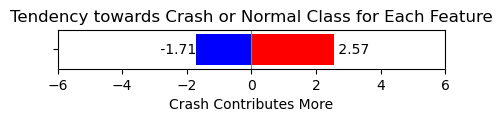

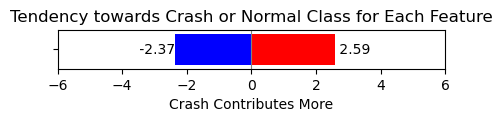

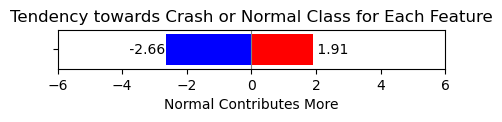

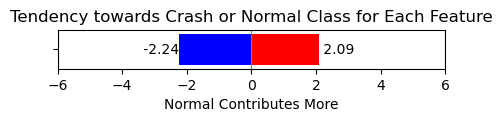

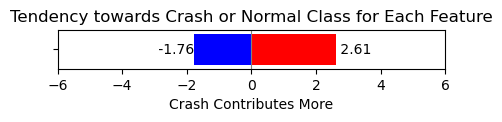

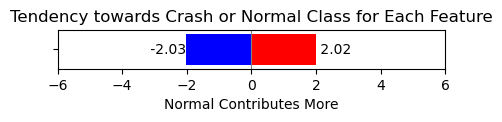

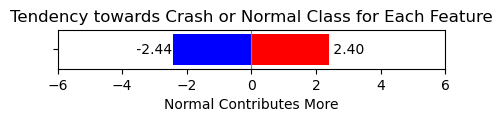

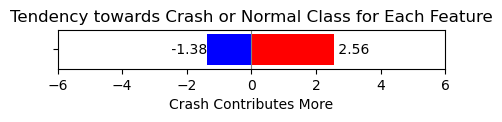

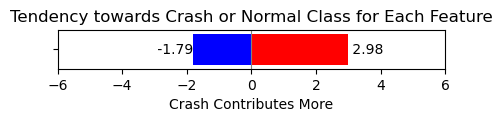

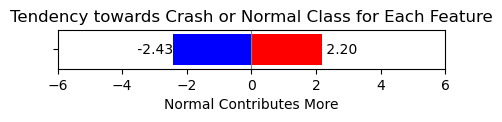

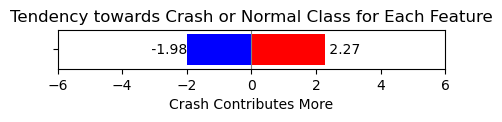

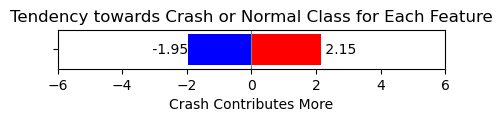

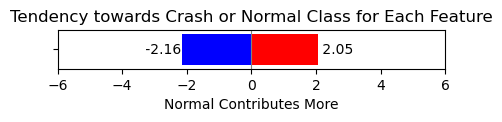

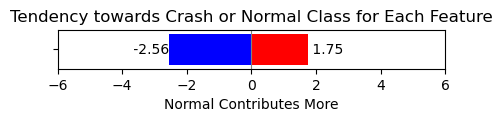

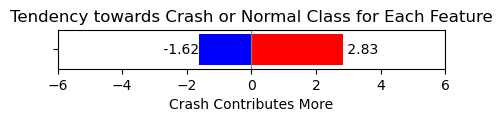

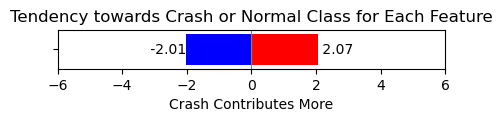

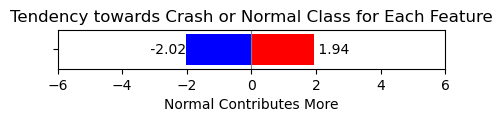

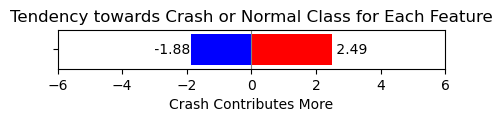

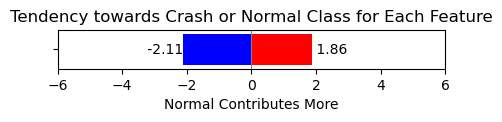

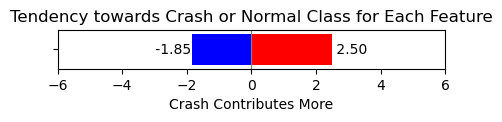

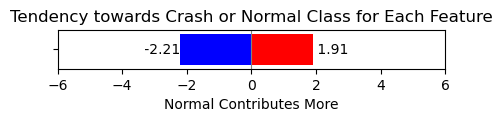

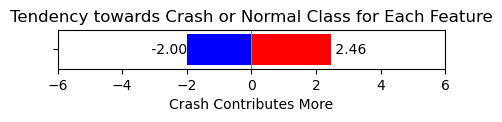

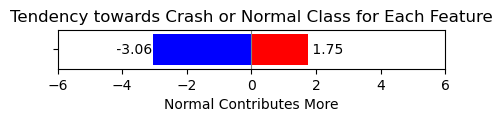

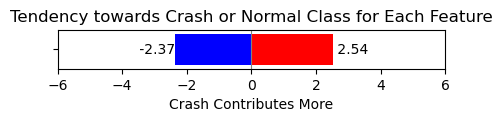

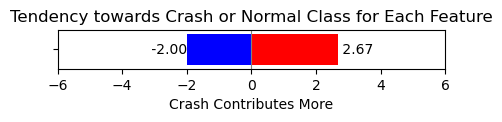

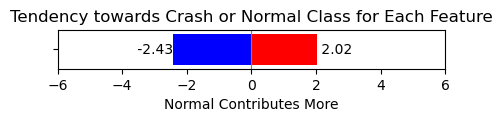

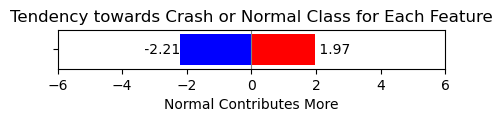

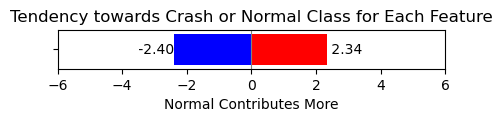

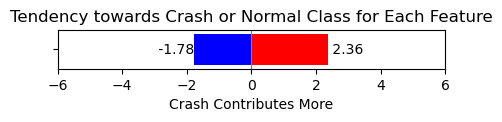

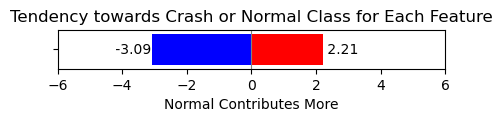

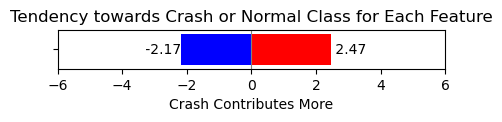

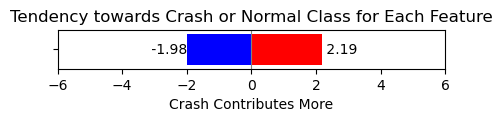

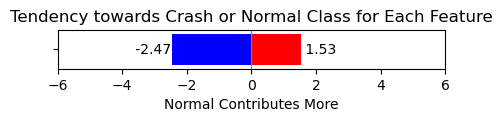

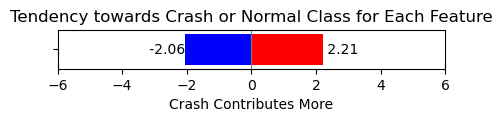

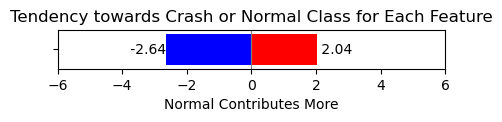

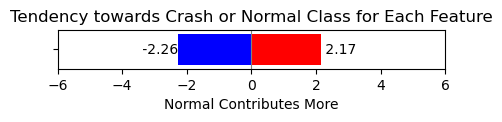

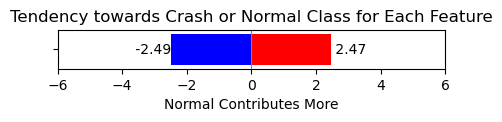

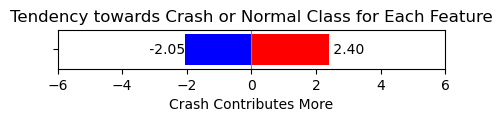

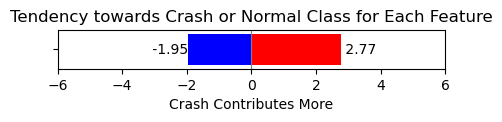

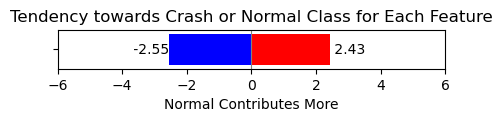

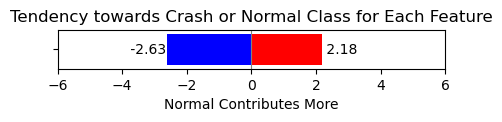

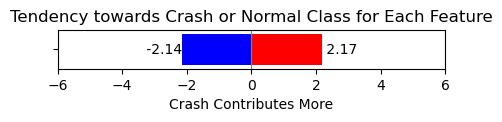

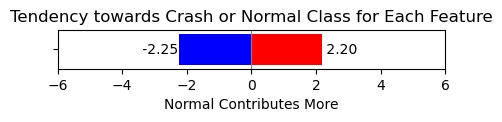

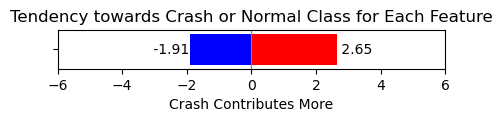

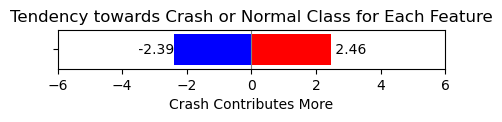

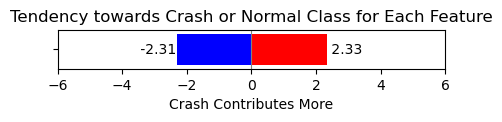

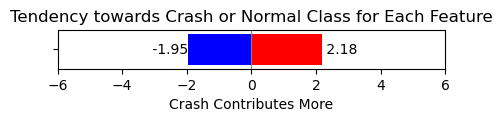

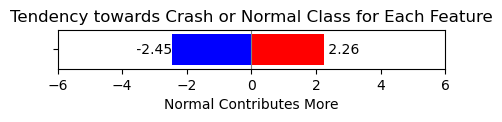

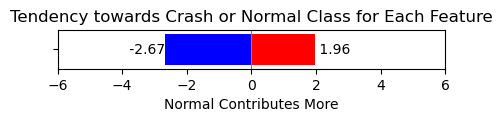

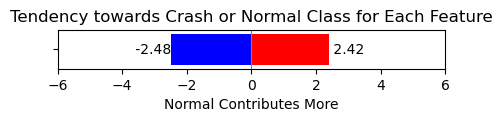

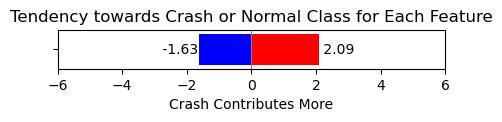

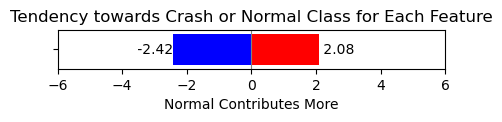

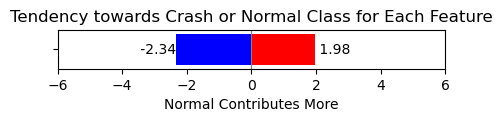

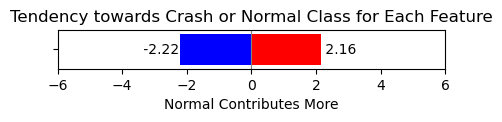

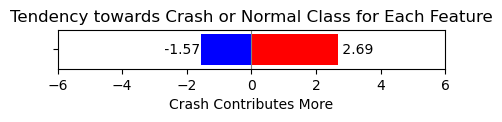

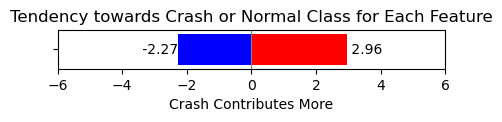

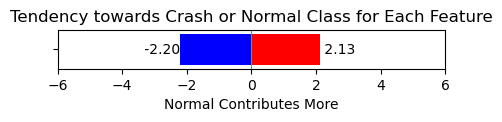

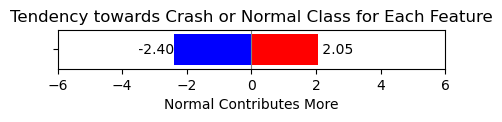

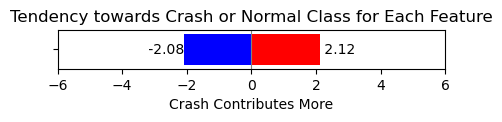

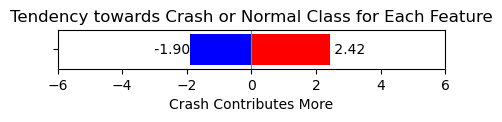

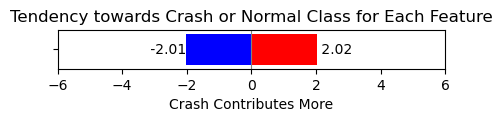

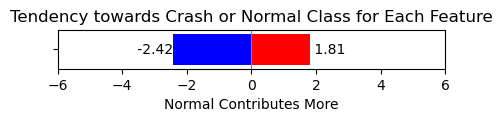

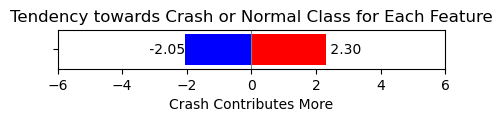

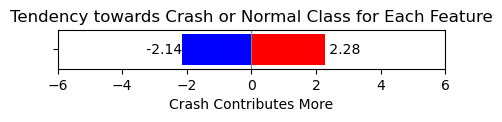

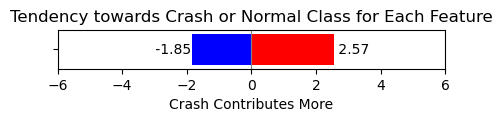

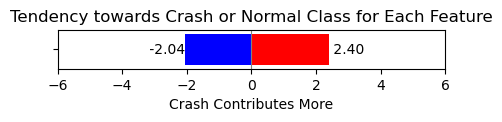

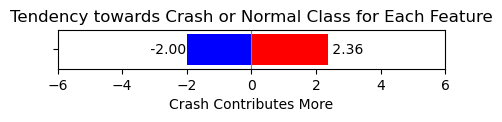

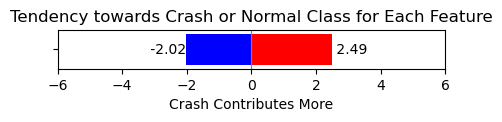

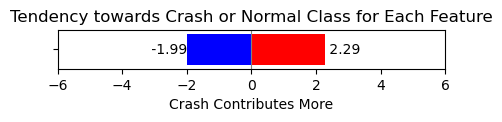

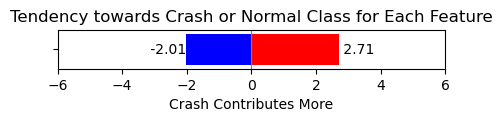

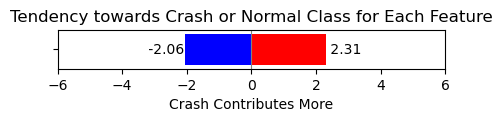

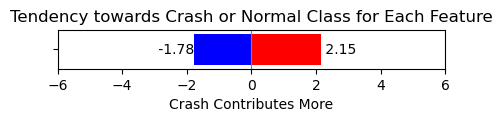

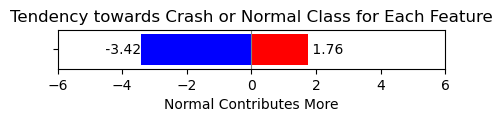

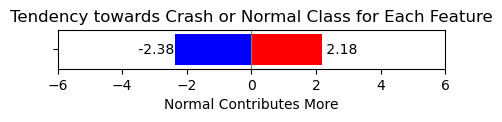

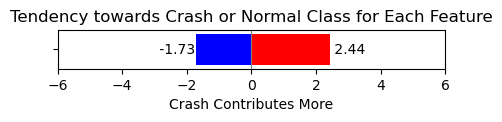

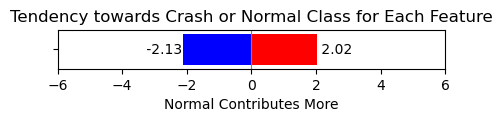

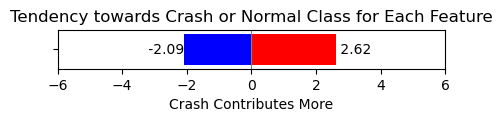

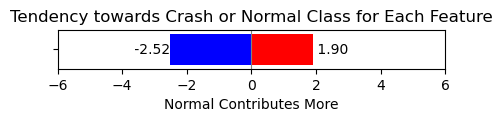

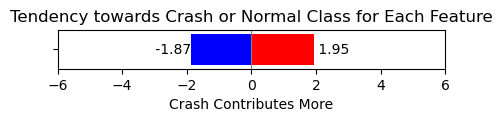

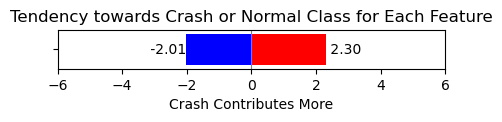

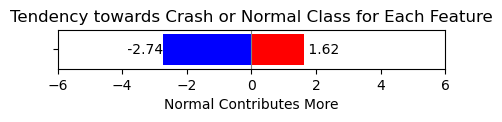

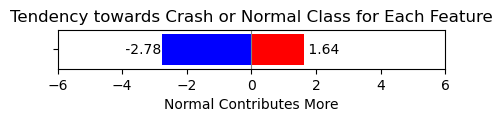

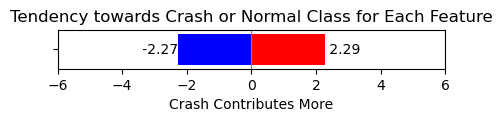

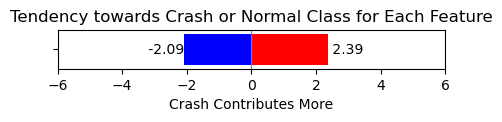

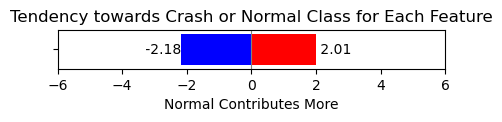

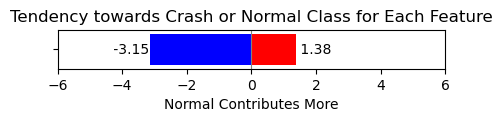

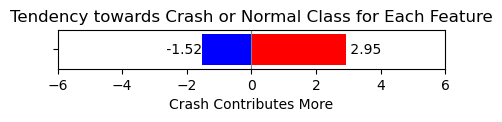

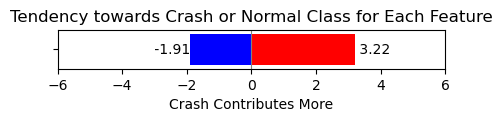

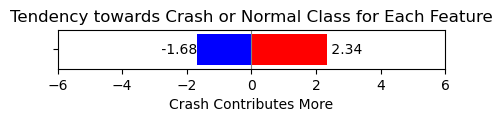

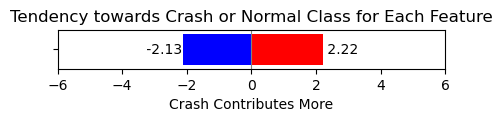

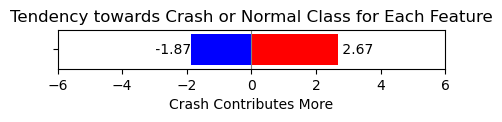

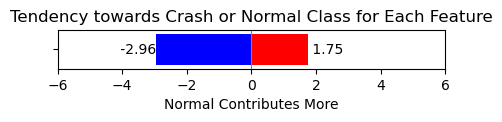

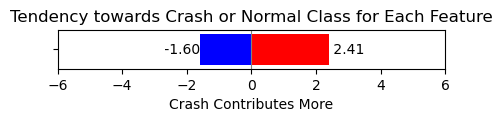

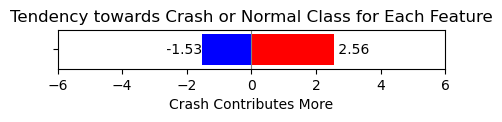

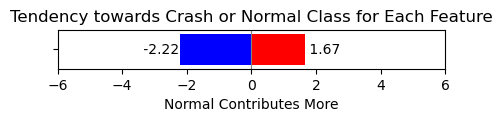

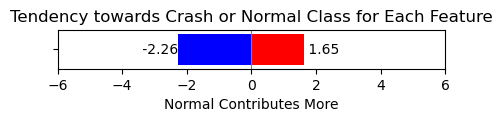

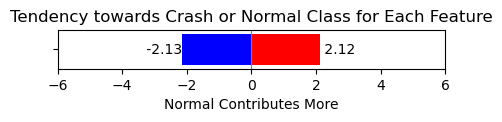

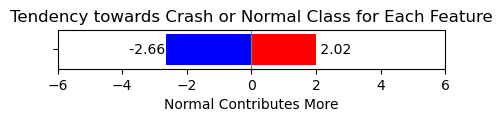

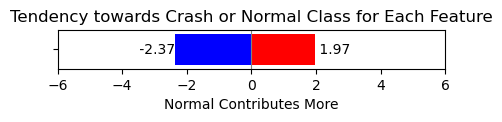

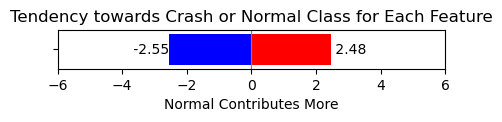

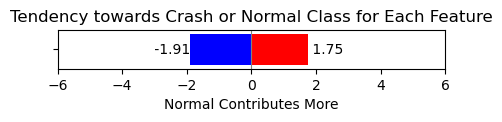

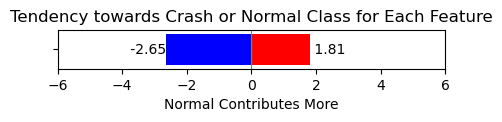

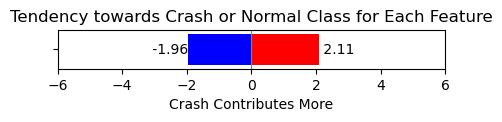

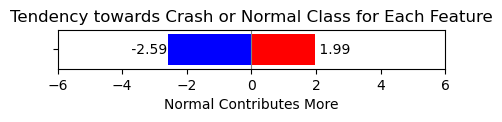

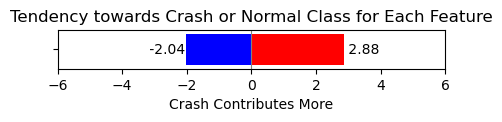

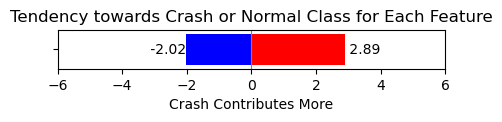

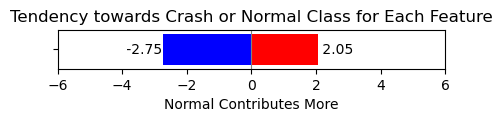

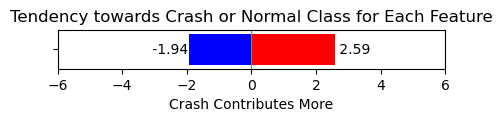

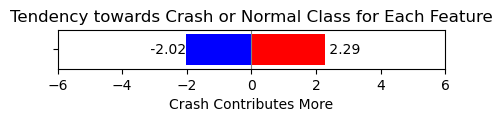

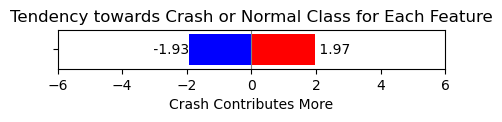

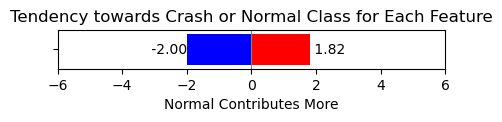

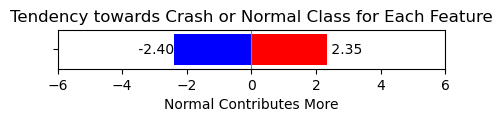

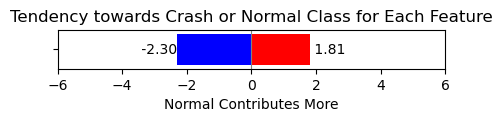

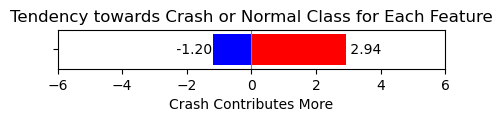

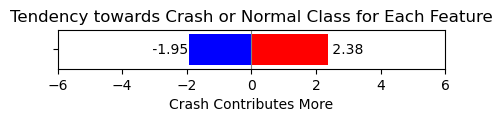

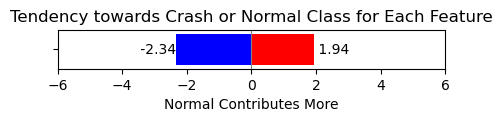

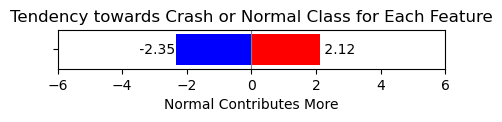

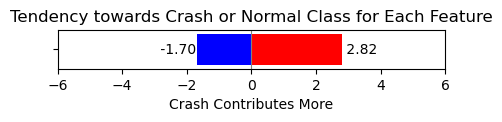

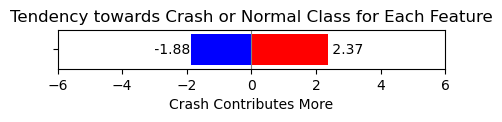

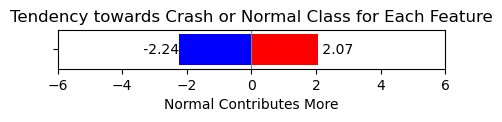

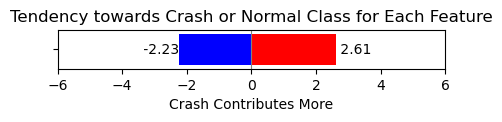

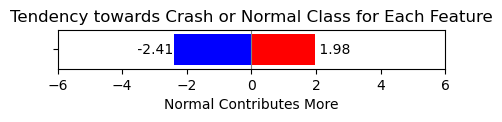

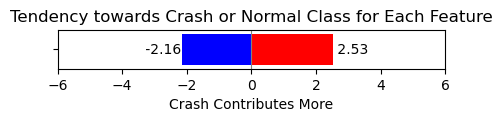

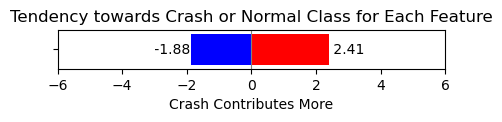

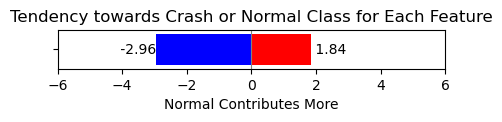

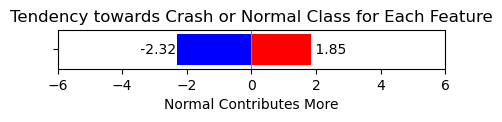

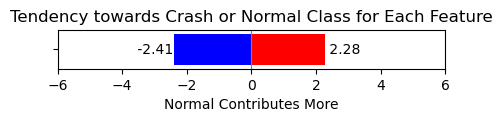

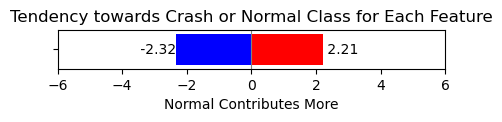

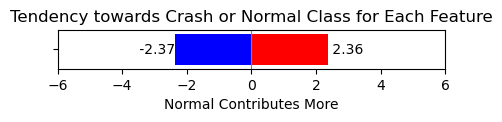

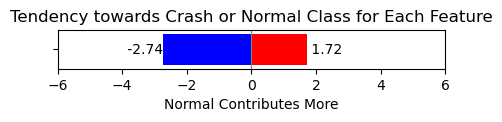

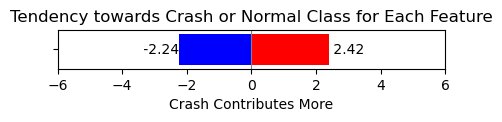

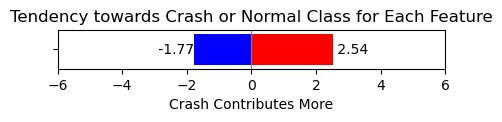

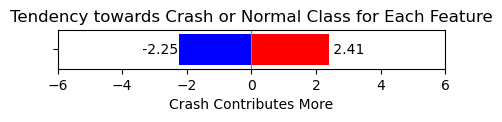

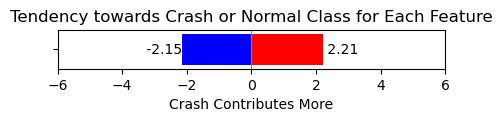

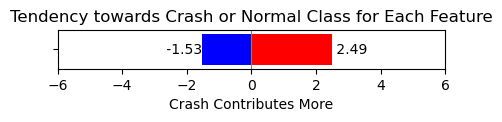

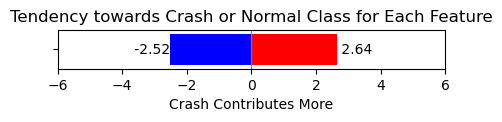

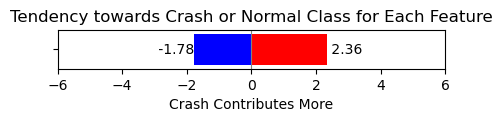

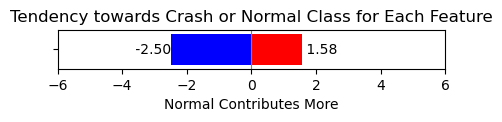

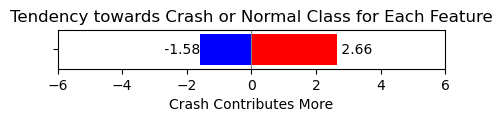

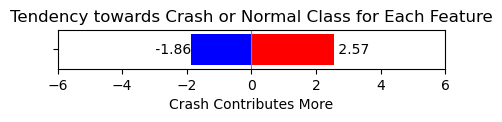

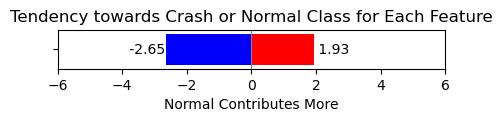

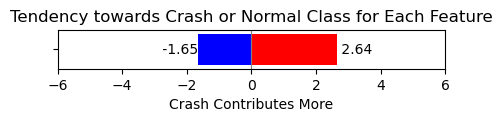

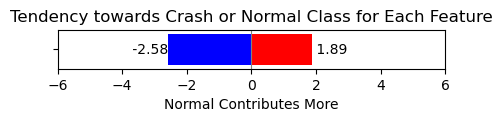

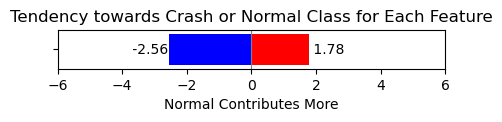

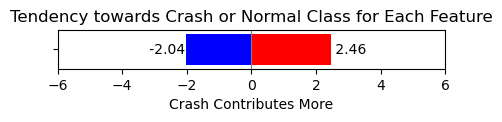

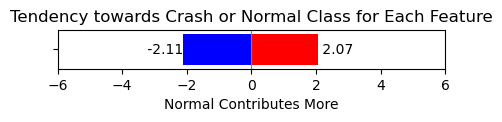

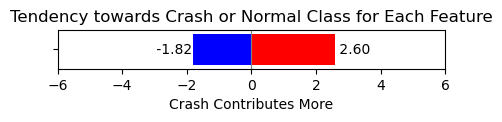

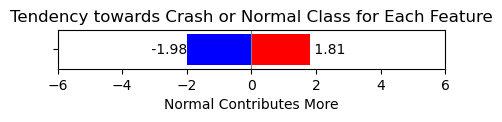

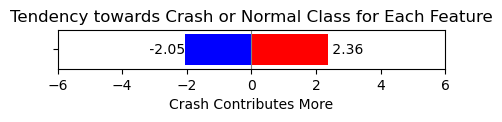

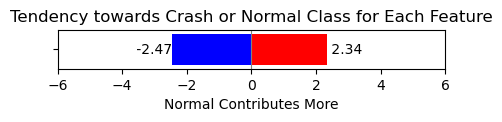

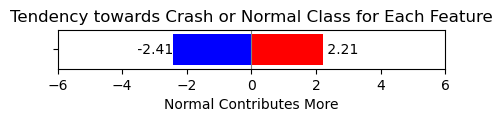

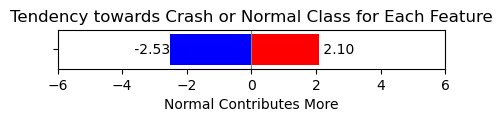

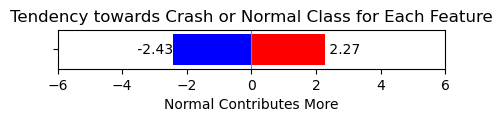

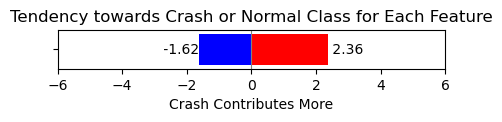

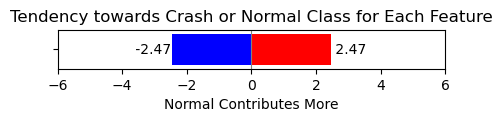

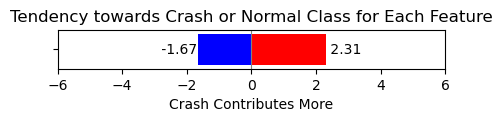

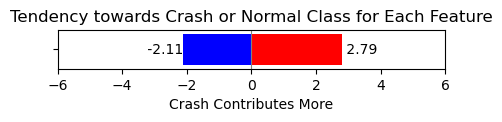

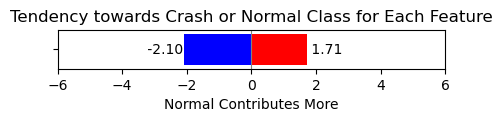

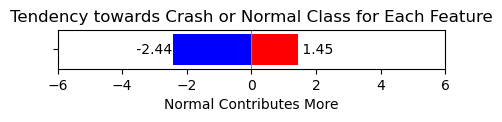

In [65]:
rows_as_lists = weight_matrix_last_df.values.tolist()

normal_contribution_count = 0

for row in rows_as_lists:
    
    crash_contribution = 0
    normal_contribution = 0
    
    for element in row:
        if (element < 0):
            normal_contribution += element
        else:
            crash_contribution += element
    
    # Values to plot
    values = [crash_contribution, normal_contribution]
    categories = ['']
    
    # Create a horizontal bar graph
    plt.figure(figsize=(5, 0.5))
    bars = plt.barh(categories, values, color=['red', 'blue'])

    # Adding labels and title
    plt.title('Tendency towards Crash or Normal Class for Each Feature')
    if (abs(normal_contribution) > crash_contribution):
        plt.xlabel('Normal Contributes More')
        normal_contribution_count += 1
    else:
        plt.xlabel('Crash Contributes More')
    plt.axvline(0, color='grey', linewidth=0.8)
    plt.xlim(-6, 6)
    plt.ylim(-0.5, 0.5)

    # Add text labels directly on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f' {value:.2f}',
                 va='center', ha='right' if value < 0 else 'left', color='black')
    plt.show()

**Possibly Bias towards Classifying Videos to Normal Class**

# 1111

## 3. 这个没弄好，可能需要接手

In [58]:
# Misclassified Test Videos

misclassified = []

for i in range(len(pred)):
    if pred[i] != true[i]:
        misclassified.append(i)
        
misclassified

[2, 4, 5, 7]

In [59]:
""" REFERENCE

EMBED_DIM = 64
PATCH_SIZE = 8,8,8
INPUT_SHAPE = (50, 128, 128, 1)
NUM_HEADS = 6

"""

# The below codes are similar to the codes in line 33-62 
#              in the `create_vivit_classifier` function
def preprocess_frames(frames: tf.Tensor):
    """Preprocess the frames tensors for prediction."""
    frames = tf.image.convert_image_dtype(
        frames[..., tf.newaxis],  # Add a channel dimension if needed
        tf.float32,
    )
    return frames

# Define the model up to the attention layer
# The below codes are similar to the codes in line 33-62 
#              in the `create_vivit_classifier` function
inputs = layers.Input(shape=INPUT_SHAPE)
tubelet_embedder = TubeletEmbedding(embed_dim=EMBED_DIM, patch_size=PATCH_SIZE)
patches = tubelet_embedder(inputs)
positional_encoder = PositionalEncoder(embed_dim=EMBED_DIM)
encoded_patches = positional_encoder(patches)
x = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)
attention_output = multi_head_attention(x, x)

# Model Building
model = models.Model(inputs=inputs, outputs=attention_output)

# Dummy data to simulate an input
# Should we use one of the test data here?

import tensorflow as tf

# Assuming test_videos[0] is a numpy array and needs to be converted to a TensorFlow tensor
video_tensor = tf.convert_to_tensor(test_videos[0], dtype=tf.float32)
preprocessed_video = preprocess_frames(video_tensor)
preprocessed_video = tf.expand_dims(preprocessed_video, axis=0)
attention = model.predict(preprocessed_video)

print(attention)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[[-0.08645728 -0.01818185  0.04557808 ... -0.04915994 -0.04159524
   -0.08774397]
  [-0.08934183 -0.01717143  0.04743646 ... -0.04901168 -0.04305458
   -0.0882909 ]
  [-0.08716104 -0.01761697  0.04638793 ... -0.04908247 -0.0438057
   -0.08836776]
  ...
  [-0.08782692 -0.01826489  0.04688556 ... -0.04904728 -0.04409932
   -0.08871816]
  [-0.08846837 -0.01867196  0.04675393 ... -0.04941053 -0.04264785
   -0.08832578]
  [-0.08785257 -0.01790616  0.04598612 ... -0.0492804  -0.04219846
   -0.08789608]]]


In [61]:
# How do we visualizae it?

"""
(1)
Since each token represents an 8x8x8 patch of the video, 
you can reconstruct attention maps over the video frame-by-frame or as summed-up projections. 
By mapping these attention weights back onto the video frames, you can see which areas are being focused on.

(2)
ou can aggregate attention weights across different frames to see 
if there's a temporal pattern in how the model attends to different regions of the video.

(3)
Generate heatmaps for individual frames or average them across a sequence to visually 
represent where the model is "looking."
"""

attention.shape  # (1, 1536, 64) 

# (Batch Size (1), Num of Tokens (1526), Embedding Dimension (64))
# Each token represents an 8x8x8 patch of the video

(1, 1536, 64)

Attention Scores Calculation: The attention mechanism calculates scores by performing a dot product of the query with all keys for each head. These scores determine how much focus (or attention) should be given to other parts of the input for each element in the output.

Aggregated Information: Each element in the output tensor represents an aggregation of information from other parts of the input, weighted by the calculated attention scores. This aggregation is tailored to maximize the relevance of the input features for the task the model is designed to perform (e.g., predicting the next word in a sentence, identifying objects in an image).